In [95]:
import h5py
import torch
import torch.nn as nn
import random


import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tempfile import TemporaryFile
from scipy.io import loadmat
import config
# import skfuzzy as fuzz

In [96]:
from torch.utils.data import DataLoader, TensorDataset

In [97]:
FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
print(FILE_PATH)

/home/thien/Hprediction/H_est_cGAN/Channel_Estimation_cGAN/Torch_code


In [98]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [99]:
# Configuration
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

BATCH_SIZE = 32 #64  # Batch size
NUM_EPOCHS = 20


In [100]:
# rows from DeepMIMO dataset settings
# change rows according to the .mat dataset file 
rows = [['550', '568']] # , ['5100','5109']
rowss = "550_568"
snr = 0 # dB

In [101]:
# file path
outer_file_path = os.path.join(FILE_PATH, '..', 'DeepMIMOv2', 'Gan_Data', 'Static_612x14', 'freq_symb_1ant_612sub')

H_true = np.empty((0, 2, 612, 14)) # true channel

H_equal = np.empty((0, 2, 612, 14)) # noisy channel # LS channel
H_linear = np.empty((0, 2, 612, 14)) # noisy channel # LS+Linear Interpolated channel
H_practical = np.empty((0, 2, 612, 14)) # noisy channel # Practical Estimated channel

# read data from ifferent .mat file, then concatenate them
for i in range(len(rows)):
    file_path_partial = 'Gan_0_dBOutdoor1_60_1ant_612subcs_Row_' + rows[i][0] +'_' + rows[i][1] + '.mat'

    file_path = os.path.join(outer_file_path, file_path_partial)
    file_path = os.path.normpath(file_path)
    file = h5py.File(file_path, 'r')
    
    H_true = np.concatenate((H_true, np.array(file['H_data'])), axis = 0) # N_samples x channel(2) x height(614) x width(14)
    H_equal = np.concatenate((H_equal, np.array(file['H_equalized_data'])), axis = 0)
    H_linear = np.concatenate((H_linear, np.array(file['H_linear_data'])), axis=0)
    H_practical = np.concatenate((H_practical, np.array(file['H_practical_data'])), axis=0)

H_true.shape

(3439, 2, 612, 14)

# One-shot to ETS map-based channel

In [145]:
import os

project_directory = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
print("project_directory = ", project_directory)

mat_data_dir = os.path.join(project_directory, "CDL Customization/Data/test.mat")

# mat_data_dir = os.path.join(project_directory, "CDL Customization/Data"+ rowss, str(snr) + "dB.mat")
mat_data = scipy.io.loadmat(mat_data_dir)

project_directory =  /home/thien/Hprediction/H_est_cGAN/Channel_Estimation_cGAN


In [190]:
def unsqueeze_H(np_array):
    # Convert the NumPy array to a PyTorch tensor
    tensor = torch.tensor(np_array, dtype=torch.complex64)

    # Create a new tensor with shape (1, 2, 612, 14)
    # First, get the real and imaginary parts
    real_part = tensor.real.unsqueeze(0)  # Shape (1, 612, 14)
    imag_part = tensor.imag.unsqueeze(0)  # Shape (1, 612, 14)

    # Then, concatenate them along a new dimension
    combined = torch.cat((real_part, imag_part), dim=0)  # Shape (2, 612, 14)

    # Finally, add a batch dimension to get shape (1, 2, 612, 14)
    result_tensor = combined.unsqueeze(0)  # Shape (1, 2, 612, 14)
        
    return result_tensor


In [191]:
etsH_LS   = mat_data['H_equalized']
etsH_LI   = mat_data['H_linear']
etsH_true = mat_data['H_true']

### Normalized etsH_LS and etsH_LI based on the saved train_min, max 

In [ ]:
# saved variable file path 
saved_var_file = ''  # CNN_2_variable.pth
load_var = torch.load(saved_var_file)

# load saved train_min,max, val_min_max
train_min_LI = load_var['train_min_LI']
train_max_LI = load_var['train_max_LI']
train_min_LS = load_var['train_min_LS']
train_max_LS = load_var['train_max_LS']
val_min = load_var['val_min']
val_max = load_var['val_max']

In [192]:
etsH_LS_tensor = unsqueeze_H(etsH_LI) # (1,2,612,14)
etsH_LI_tensor = unsqueeze_H(etsH_LI) # (1,2,612,14)
etsH_true_tensor = unsqueeze_H(etsH_LI) # (1,2,612,14)

etsH_LS_normd = (etsH_LS_tensor - train_min_LS) * (train_max_LS - train_min_LS)
etsH_LI_normd = (etsH_LI_tensor - train_min_LI) * (train_max_LI - train_min_LI)
etsH_true_normd = (etsH_true_tensor - val_min) * (val_max - val_min)   
                                            # for the estimated channel, we will need to de-normalized

### Visualize Data and Label

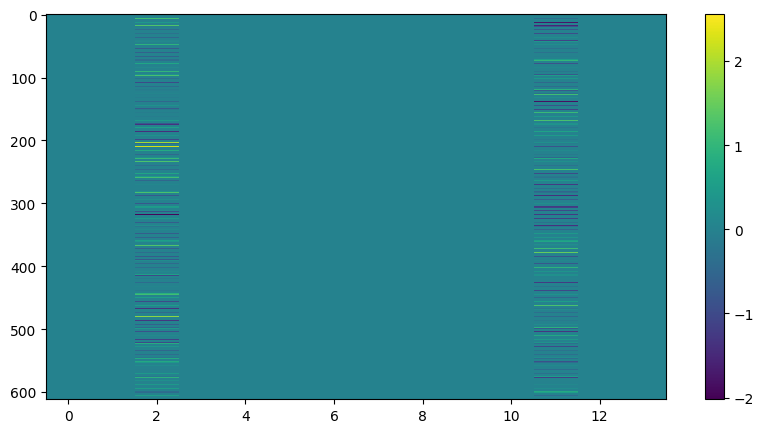

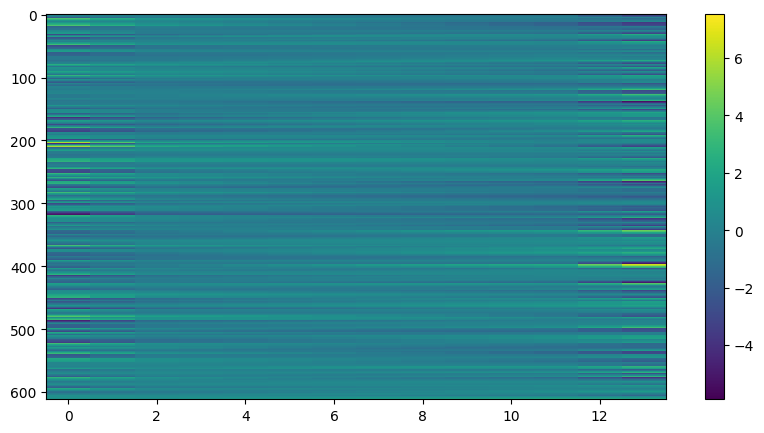

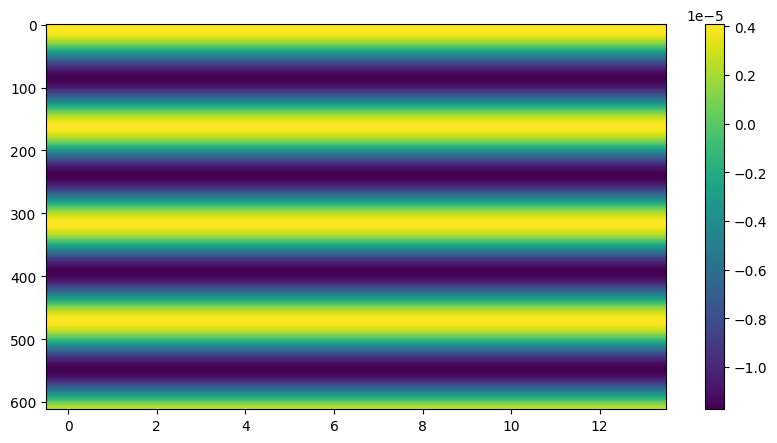

In [147]:
plt.figure(figsize=(10, 5))
plt.imshow(np.real(etsH_LS[:,:]),  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS Map-based channel normalized by training settings')
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(np.real(etsH_LI[:,:]),  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS+LI Map-based channel normalized by training settings')
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(np.real(etsH_true[:,:]),  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('True channel normalized by validating settings')
plt.colorbar()
plt.show()

## (LS+LI) model 

In [ ]:
etsH_LI_normd_real = etsH_LI_normd[:,0,:,:].unsqueeze(1)
etsH_LI_normd_imag = etsH_LI_normd[:,1,:,:].unsqueeze(1)

etsH_LS_normd_real = etsH_LS_normd[:,0,:,:].unsqueeze(1)
etsH_LS_normd_imag = etsH_LS_normd[:,1,:,:].unsqueeze(1)

etsH_true_normd_real = etsH_true_normd[:,0,:,:].unsqueeze(1)
etsH_true_normd_imag = etsH_true_normd[:,1,:,:].unsqueeze(1)

In [ ]:
ets_model = CNN_Est()
LI_model_path = os.path.join(save_folder,  'CNN_' +str(index_save)+'_LI_CNN_model.pth')
saved_model = torch.load(LI_model_path)

ets_model.load_state_dict(saved_model['model_state_dict'])
optimizer.load_state_dict(saved_model['optimizer_state_dict'])

In [196]:
model_cpu = model.to('cpu')

In [197]:
ets_estimatedLI_real = model_cpu(etsH_LI_normd_real)
# similar with imag part

In [207]:
ets_estimatedLI_real.device
tensor_for_plot = ets_estimatedLI_real[0, 0, :, :].detach().cpu().numpy()

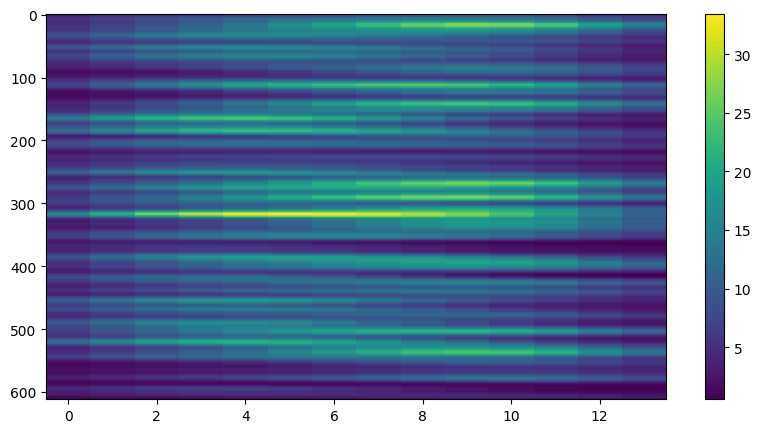

In [209]:
plt.figure(figsize=(10, 5))
plt.imshow(tensor_for_plot[:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

In [ ]:
# de-normalized the output
# load saved variable
# De-normalized
H_val_NN_denormd = H_NN_val * (trainLabels_max - trainLabels_min) + trainLabels_min
H_val_NN_denormd = H_val_NN_denormd.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(H_val_NN_denormd[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

In [ ]:
# calculate MSE

# calculate NMSE 

## (LS-only)-preprocessed model 